#Clone Repository

In [38]:
!rm -rf *
!rm -rf .git* .config
!ls -la

total 12
drwxr-xr-x 1 root root 4096 Jun 23 12:45 .
drwxr-xr-x 1 root root 4096 Jun 23 08:40 ..


In [39]:
!git clone https://github.com/manuhg/yolo_retrain.git .

Cloning into '.'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 79 (delta 37), reused 66 (delta 24), pack-reused 0
Unpacking objects: 100% (79/79), done.


# Do it at once

In [3]:
!python train.py -d . -ts Pascal_VOC -m yolov2-tiny

pip -q install natsort 
Cloning darknet repository
Cloning into 'dkn'...
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.16 MiB | 4.12 MiB/s, done.
Resolving deltas: 100% (3922/3922), done.
git clone https://github.com/pjreddie/darknet.git dkn 
mv -v dkn/* ./ renamed 'dkn/LICENSE' -> './LICENSE'
renamed 'dkn/LICENSE.fuck' -> './LICENSE.fuck'
renamed 'dkn/LICENSE.gen' -> './LICENSE.gen'
renamed 'dkn/LICENSE.gpl' -> './LICENSE.gpl'
renamed 'dkn/LICENSE.meta' -> './LICENSE.meta'
renamed 'dkn/LICENSE.mit' -> './LICENSE.mit'
renamed 'dkn/LICENSE.v1' -> './LICENSE.v1'
renamed 'dkn/Makefile' -> './Makefile'
renamed 'dkn/README.md' -> './README.md'
renamed 'dkn/cfg' -> './cfg'
renamed 'dkn/data' -> './data'
renamed 'dkn/examples' -> './examples'
renamed 'dkn/include' -> './include'
renamed 'dkn/python' -> './python'
renamed 'dkn/scripts' -> './scripts'
renamed 'dkn/src' -> './src'

sed -i 's/GPU=

 # Do it step by step

## Get  Pascal VOC dataset

In [4]:
!wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
!tar xf VOCtrainval_11-May-2012.tar
!tar xf VOCtrainval_06-Nov-2007.tar
!tar xf VOCtest_06-Nov-2007.tar

!wget https://pjreddie.com/media/files/voc_label.py
!python voc_label.py

!cat 2007_train.txt 2012_*.txt > train.txt

!cp 2007_val.txt test.txt

!cp data/voc.names classes.txt

!mkdir bkup
!mv 2* bkup/
!mv *.tar bkup/

--2019-06-23 09:04:55--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘VOCtrainval_11-May-2012.tar.1’

l_11-May-2012.tar.1   5%[>                   ] 113.80M  29.0MB/s    eta 70s    

KeyboardInterrupt: ignored

## Get NFPA dataset

In [9]:
!pip install gdown

In [10]:
!gdown https://drive.google.com/uc?id=1_gJcci9p6cS0EucumFt2gpwA0tqgP7_f&export=download

Downloading...
From: https://drive.google.com/uc?id=1_gJcci9p6cS0EucumFt2gpwA0tqgP7_f
To: /content/NFPA_dataset.zip
20.4MB [00:00, 44.0MB/s]


In [24]:
!unzip NFPA_dataset.zip

Archive:  NFPA_dataset.zip
   creating: NFPA dataset/
  inflating: NFPA dataset/pos-1.jpg  
  inflating: NFPA dataset/pos-1.txt  
  inflating: NFPA dataset/pos-100.jpg  
  inflating: NFPA dataset/pos-100.txt  
  inflating: NFPA dataset/pos-101.jpg  
  inflating: NFPA dataset/pos-101.txt  
  inflating: NFPA dataset/pos-102.jpg  
  inflating: NFPA dataset/pos-102.txt  
  inflating: NFPA dataset/pos-103.jpg  
  inflating: NFPA dataset/pos-103.txt  
  inflating: NFPA dataset/pos-104.jpg  
  inflating: NFPA dataset/pos-104.txt  
  inflating: NFPA dataset/pos-105.jpg  
  inflating: NFPA dataset/pos-105.txt  
  inflating: NFPA dataset/pos-106.jpg  
  inflating: NFPA dataset/pos-106.txt  
  inflating: NFPA dataset/pos-107.jpg  
  inflating: NFPA dataset/pos-107.txt  
  inflating: NFPA dataset/pos-108.jpg  
  inflating: NFPA dataset/pos-108.txt  
  inflating: NFPA dataset/pos-109.jpg  
  inflating: NFPA dataset/pos-109.txt  
  inflating: NFPA dataset/pos-110.jpg  
  inflating: NFPA dataset/pos-

In [23]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
!mv 'NFPA dataset' data/nfpa

In [0]:
!cp nfpa/data/train.txt ./
!cp nfpa/data/test.txt ./
!printf "NFPA" > classes.txt

## Train

### Prepare config

In [0]:
data_dir = '.'
class_names_file = 'classes.txt'
batch_size, subdivisions = int('64'), int('8')
model_name='yolov2'
model_url='https://pjreddie.com/media/files/darknet19_448.conv.23'
filename='yolo_custom.cfg'

import os
import sys
import subprocess
from gen_files import gen
import argparse

def exec_cmd(cmdstr):
    print(cmdstr,os.popen(cmdstr).read())

In [41]:
if not os.path.isfile('./darknet'):
    print('Cloning darknet repository')
    exec_cmd('git clone https://github.com/pjreddie/darknet.git dkn')
    exec_cmd('mv -v dkn/* ./')
    exec_cmd("sed -i 's/GPU=0/GPU=1/;s/CUDNN=0/CUDNN=1/;s/OPENCV=0/OPENCV=1/;s/OPENMP=0/OPENMP=1/;' Makefile")
    exec_cmd('make -j8')

if not os.path.isfile('darknet19_448.conv.23'):
    print('Downloading darknet model')
    exec_cmd('wget '+model_url)

Cloning darknet repository
git clone https://github.com/pjreddie/darknet.git dkn 
mv -v dkn/* ./ renamed 'dkn/LICENSE' -> './LICENSE'
renamed 'dkn/LICENSE.fuck' -> './LICENSE.fuck'
renamed 'dkn/LICENSE.gen' -> './LICENSE.gen'
renamed 'dkn/LICENSE.gpl' -> './LICENSE.gpl'
renamed 'dkn/LICENSE.meta' -> './LICENSE.meta'
renamed 'dkn/LICENSE.mit' -> './LICENSE.mit'
renamed 'dkn/LICENSE.v1' -> './LICENSE.v1'
renamed 'dkn/Makefile' -> './Makefile'
renamed 'dkn/README.md' -> './README.md'
renamed 'dkn/cfg' -> './cfg'
renamed 'dkn/data' -> './data'
renamed 'dkn/examples' -> './examples'
renamed 'dkn/include' -> './include'
renamed 'dkn/python' -> './python'
renamed 'dkn/scripts' -> './scripts'
renamed 'dkn/src' -> './src'

sed -i 's/GPU=0/GPU=1/;s/CUDNN=0/CUDNN=1/;s/OPENCV=0/OPENCV=1/;s/OPENMP=0/OPENMP=1/;' Makefile 
make -j8 mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-resu

In [28]:
with open(data_dir+'/'+class_names_file) as f:
            class_names = list(
                map(lambda s: s.replace('\n', '').strip(), f.readlines()))
            class_names = list(filter(None,class_names))

data_file, names_file, cfg_file = gen(
    class_names, model_name=model_name, batch_size=batch_size, subdivisions=subdivisions, filename=filename)
flag = True
print(data_file, names_file, cfg_file)

Configuring to train  yolov2  classes: 1
cp cfgs/yolov2.cfg cfg/yolo_custom.cfg 
sed -i '6s/.*/batch=64/;7s/.*/subdivisions=8/;237s/.*/filters=30/;244s/.*/classes=1/;' 'cfg/yolo_custom.cfg' 
cfg/obj.data cfg/obj.names cfg/yolo_custom.cfg


###  Train the model

#### sub process

In [0]:
print('Traning the model')
cmd = './darknet detector train '+data_file +' '+cfg_file+' darknet19_448.conv.23'
p = subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1,shell = True)
for line in iter(p.stdout.readline,''):
    print(line)
p.stdout.close()
p.wait()

#### Direct commandline

In [29]:
!./darknet detector train cfg/obj.data cfg/yolo_custom.cfg darknet19_448.conv.23

yolo_custom
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 max          2 x 2 / 2   608 x 608 x  32   ->   304 x 304 x  32
    2 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    3 max          2 x 2 / 2   304 x 304 x  64   ->   152 x 152 x  64
    4 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    5 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    6 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    7 max          2 x 2 / 2   152 x 152 x 128   ->    76 x  76 x 128
    8 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
    9 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
   10 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   11 max          2 x 2 / 2    76 x  7

In [32]:
cat data/nfpa/pos-261.txt

0 0.56953125 0.5848623853211009 0.019270833333333334 0.03394495412844037


In [0]:
import cv2
from PIL import Image

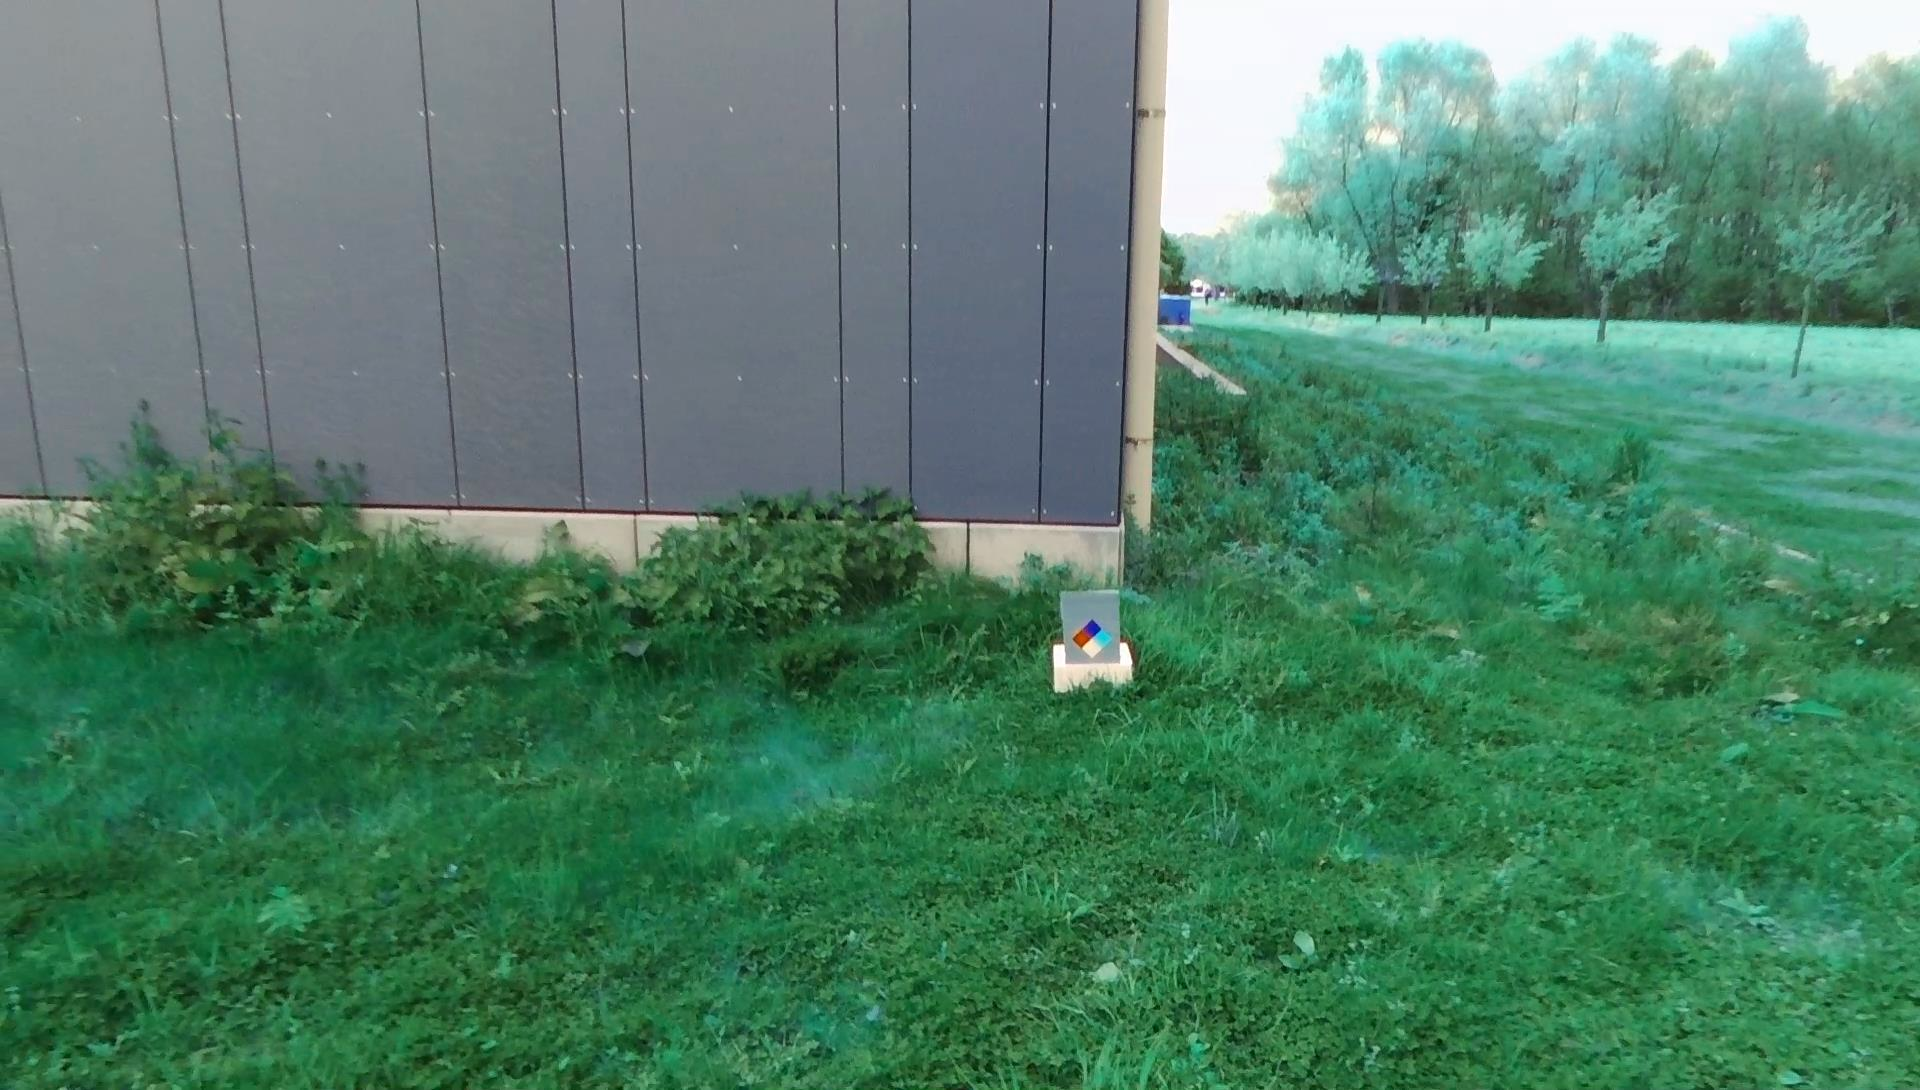

In [37]:
Image.fromarray(cv2.imread('data/nfpa/pos-261.jpg'))